<a href="https://colab.research.google.com/github/mitchwolfe1/Crypto-PD/blob/main/Crypto_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [22]:
data = pd.read_csv("all.txt")
data = data.iloc[:, 1:3]
data.columns = ["Time", "Price"]

In [23]:
data.head()

,Time,Price
0,2021-09-30 17:15:00,0.000017
1,2021-09-30 17:30:00,0.000018
2,2021-09-30 17:45:00,0.000018
3,2021-09-30 18:00:00,0.000018
4,2021-09-30 18:15:00,0.000018


In [24]:
data.shape

(6570, 2)

### We are training off of the market price at each 15 minute interval

In [66]:
# We are looking at the data in 1000 chunk increments
# We save the first 980 lines for training
# The last 20 are for training
# We will build a predictive model based off of the first 980 lines 
# and try to predict the next 20
# Based off our predictions we will have a short term trading strategy
# And try that
all_training_data = [data.iloc[(i*1000):(i+1)*1000 - 20, 1:2].values for i in range(6)]
all_testing_data = [data.iloc[(i+1)*1000 - 20: (i+1)*1000, 1:2].values for i in range(6)]
all_total_data = [data.iloc[(i*1000): (i+1)*1000, 1:2] for i in range(6)]

In [34]:
all_training_data[0][:5]

array([[1.741e-05],
       [1.755e-05],
       [1.752e-05],
       [1.753e-05],
       [1.753e-05]])

## Training for One Data Sample

In [67]:
train, test, total = all_training_data[0], all_testing_data[0], all_total_data[0]

In [37]:
# We are normaling our pricing data
ss= MinMaxScaler(feature_range=(0,1))
train_scaled= ss.fit_transform(train)

In [43]:
# We will have 20 look backs, 
#for a total of 5 hours of post event knowledge
train_scaled[20]

array([0.20941176])

In [52]:
x_train = []
y_train = []
for i in range(20,len(train_scaled)):
    x_train.append(train_scaled[i-20:i,0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [53]:
# Reshape the train data for LSTM input 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [54]:
x_train.shape

(960, 20, 1)

## Building LSTM model

In [55]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 20% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(x_train.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 20% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 20% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 20% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(x_train,y_train,batch_size=30,epochs=100)

Epoch 1/100
32/32 [==============================] - 6s 32ms/step - loss: 0.0317
Epoch 2/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0101
Epoch 3/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0094
Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0094
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0094
Epoch 6/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0095
Epoch 7/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0077
Epoch 8/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0082
Epoch 9/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0083
Epoch 10/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0077
Epoch 11/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0069
Epoch 12/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0070
Epoch 13/100
32/32 [=====

In [69]:
test_input = total[len(total)-len(test)-20:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [72]:
xtest= []
for i in range(20,40):
    xtest.append(test_input[i-20:i,0]) 

In [73]:
xtest= np.array(xtest)

In [74]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

In [75]:
predicted_value = ss.inverse_transform(predicted_value)

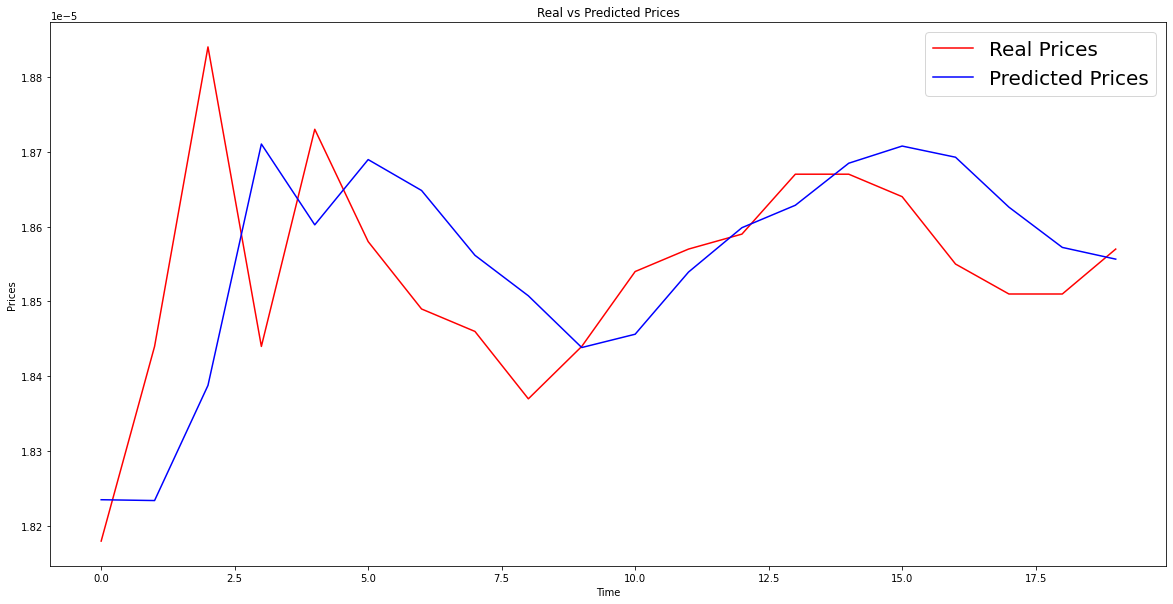

In [77]:
plt.figure(figsize=(20,10))
plt.plot(test,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

## Running for all samples

In [ ]:
for i in range(6):
  train, test, total = all_training_data[i], all_testing_data[i], all_total_data[i]

  ss= MinMaxScaler(feature_range=(0,1))
  train_scaled= ss.fit_transform(train)

  x_train = []
  y_train = []
  for i in range(20,len(train_scaled)):
      x_train.append(train_scaled[i-20:i,0])
      y_train.append(train_scaled[i,0])

  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #initialisizng the model 
  regression= Sequential()

  #First Input layer and LSTM layer with 20% dropout
  regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(x_train.shape[1],1)))
  regression.add(Dropout(0.2))

  # Where:
  #     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

  # Second LSTM layer with 20% dropout
  regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
  regression.add(Dropout(0.2))

  #Third LSTM layer with 20% dropout
  regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
  regression.add(Dropout(0.2))

  #Fourth LSTM layer with 20% dropout, we wont use return sequence true in last layers as we dont want to previous output
  regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
  regression.add(Dropout(0.2))
  #Output layer , we wont pass any activation as its continous value model
  regression.add(Dense(units=1))

  #Compiling the network
  regression.compile(optimizer='adam',loss='mean_squared_error')


  #fitting the network
  regression.fit(x_train,y_train,batch_size=30,epochs=100)

  test_input = total[len(total)-len(test)-20:].values
  test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
  test_input= ss.transform(test_input)

  xtest= []
  for i in range(20,40):
      xtest.append(test_input[i-20:i,0]) 

  xtest= np.array(xtest)

  xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
  predicted_value= regression.predict(xtest)

  predicted_value = ss.inverse_transform(predicted_value)
  
  plt.figure(figsize=(20,10))
  plt.plot(test,'red',label='Real Prices')
  plt.plot(predicted_value,'blue',label='Predicted Prices')
  plt.xlabel('Time')
  plt.ylabel('Prices')
  plt.title('Real vs Predicted Prices')
  plt.legend(loc='best', fontsize=20)

  plt.savefig(str(i) + ".png")

Epoch 1/100
32/32 [==============================] - 6s 32ms/step - loss: 0.0348
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0103
Epoch 3/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0089
Epoch 4/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0086
Epoch 5/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0085
Epoch 6/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0084
Epoch 7/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0082
Epoch 8/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0075
Epoch 9/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0090
Epoch 10/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0077
Epoch 11/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0069
Epoch 12/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0072
Epoch 13/100
32/32 [=====